## Audio Explorer Design
sketch out ways to interact with audio, it's features, and outputs of models 

In [9]:
import sys
import os
import numpy as np
import pandas as pd
sys.path.insert(0, '../../')
from library.notebook_api.data_loader import  ModelDataLoader,CombinedDataLoader
from library.source_data.feature_extractor import AudioFeatureExtractor
from library.source_data.parallel_processor import AudioParallelProcessor
from configuration import PROJECT_ABSOLUTE_PATH,MODEL_INPUT_DATA_PATH
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import base64
from io import BytesIO

## Load Data

### Source Data

In [15]:
#instantate data_loader and the dataframes it makes available 
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']

data_loader = CombinedDataLoader('large', in_scope_labels)
df = data_loader.df
df_files_available = data_loader.df_files_available
df_genres_available = data_loader.df_genres_available
df_filtered = data_loader.df_filtered
df_filtered_in_scope = df_filtered[df_filtered['label'].apply(lambda label: True if label in in_scope_labels else False)]

tracks in meta 29701
tracks with files available in project_data_path:  29701
tracks with top level genres available 29701
tracks with genres and files (df_filtered) 29701


### Model Outputs

In [16]:
#unsupervised and supervised results 
clusters = pd.read_csv(MODEL_INPUT_DATA_PATH+'clusters.csv')[['audio_path' , 'label', '0']]
predicted_genres = pd.read_csv(MODEL_INPUT_DATA_PATH+'predicted_prob.csv')
combined_df = predicted_genres.merge(clusters, on='audio_path')
combined_df.drop(columns=['index','label'], inplace=True)

In [14]:
len(predicted_genres), len(combined_df)

(5870, 5870)

In [135]:
predicted_genres.columns

Index(['rock', 'electronic', 'hiphop', 'classical', 'jazz', 'country',
       'y_pred', 'y_true', 'index', 'audio_path'],
      dtype='object')

### Load Features Into Memory

In [28]:
SAMPLE_RATE  = 22500
SECONDS = 6
#SECONDS = 25

#combined model outputs, inner joined with source data
source_data_and_model_output_df = pd.merge(df_filtered_in_scope, combined_df, on='audio_path')
#load dataframe of 1 track per label randomly sampled from above
df_filtered_in_scope_sample = data_loader.get_data_sampled_by_label(4,source_data_and_model_output_df)
#instantiate the audio extracter to laod features to memory
audio = AudioFeatureExtractor(df_filtered_in_scope_sample,sample_rate=SAMPLE_RATE,start_sample=0,end_sample=SAMPLE_RATE*SECONDS)
audio.add_audio_data_to_df()
audio.add_numerical_features_to_df()
audio.add_mfcc_to_df()
audio.add_log_melspectrogram_to_df()

/Users/murphybre/Desktop/UMichigan/Fall2024/siads699_capstone/music_modeling_capstone/notebooks/exploratory/../../library/source_data/feature_extractor.py:139: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]


## Define User Interfaces

### html template with audio player, images and metadata

In [18]:
#functions generating inputs to HTML template

def get_log_mel_spectrogram_image_base_64(log_mel_s_):
    '''for given log melspectogram nd array, return base64 encoded string of librosa specshow heatmap'''
    fig, ax = plt.subplots()
    spectro = librosa.display.specshow(log_mel_s_,x_axis='time', y_axis='mel', fmax=8000)
    fig.colorbar(spectro, ax=ax)
    tmpfile = BytesIO()
    fig.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    plt.close()
    return encoded



def get_predicted_probs_stacked_bar_image_base_64(predicted_probs, label_names):
    #referenced from #https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html

    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    results = {
    'model 1': [round(value*100,0) for value in predicted_probs],
    #'model 2': final_values

    }
    #category_names = final_labels
    category_names = label_names

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))
    category_colors = plt.colormaps['twilight_shifted'](
        np.linspace(0.15, 0.85, data.shape[1]))
    #print(category_colors)

    #fig, ax = plt.subplots(figsize=(9.2, 5))
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        if widths >=1:
            rects = ax.barh(labels, widths, left=starts, height=0.5,
                            label=colname, color=color)

            r, g, b, _ = color
            text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
            ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    tmpfile = BytesIO()
    #fig.savefig(tmpfile, format='png')
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    plt.close()

    return encoded



def get_image_html(encoded_image):
    '''for given base64 encoded image return html image tag'''
    return f'''<img src="data:image/png;base64,{encoded_image}" alt="alt image width="100" height="100">'''

def get_audio_player_html(audio_path):
    '''returns html audio player for audio in a given local path'''
    audio_html = f'''<audio controls autoplay><source src="{audio_path}" type="audio/mpeg">Your browser does not support the audio element.</audio>'''
    return audio_html

def get_log_mel_spectrogram_html_image_array(log_melspectroram_array):
    '''for provided array of log_spectrograms, returns array of html images'''
    plt.ioff()
    html_images = []
    for lm in log_melspectroram_array:
        encoded = get_log_mel_spectrogram_image_base_64(lm)
        html = get_image_html(encoded)
        html_images.append(html)
    return html_images

def get_predicted_probs_stacked_bar_html_image_array(predicted_probs_df):
    '''for provided array of log_spectrograms, returns array of html images'''
    label_names = predicted_probs_df.columns
    plt.ioff()
    html_images = []
    for row in list(range(0, len(predicted_probs_df))):
        encoded = get_predicted_probs_stacked_bar_image_base_64(predicted_probs_df.iloc[row].values, label_names)
        html = get_image_html(encoded)
        html_images.append(html)
    return html_images

def get_audio_player_html_array(audio_paths):
    '''for provided array of audio_paths, return array of html audio players'''
    html_players = []
    for path in audio_paths:
        html_players.append(get_audio_player_html(path))
    return html_players


def get_table_rows(audio_browser_table_data):
    '''returns html for all rows in a table according to audio_browser_table_data dictionary
    expects dictionary keys to be column names, and arrays of html elements as values
    '''
    table_data_list = list(audio_browser_table_data.items())
    num_columns = len(table_data_list)
    num_rows = len(table_data_list[0][1])
    #print('num rows: ', num_rows)
    all_rows = ''
    for row_index in list(range(0,num_rows)):
       # print('row: ', row_index)
        current_row_html = "<tr>\n"
        for column_index in list(range(0,num_columns)):
            #print('column: ', column_index)
            current_row_html += "<td>" + table_data_list[column_index][1][row_index]+"</td>"
            current_row_html += "\n"
        current_row_html += "</tr>\n"
            
        all_rows += current_row_html 
    return all_rows

def get_audio_browser_html(audio_browser_table_data):
    audio_browser_header = '''
    <html>
    <head>
        <title>Table with Images</title>
        <style>
            table {{
                margin: auto;
            }}
        </style>
    </head>

    <body>
        <table border="1">
    '''
    #header for each of the keys in provided dic
    table_headers = "<tr>\n" + ''.join(f'<th>{key}</th>\n' for key in list(audio_browser_table_data.keys())) +"</tr>\n"
    audio_browser_footer = '''
        </table>
    </body>
    </html>
    '''
    #get the rows of table
    table_rows = get_table_rows(audio_browser_table_data)
    #assembles the page 
    table_html = audio_browser_header+table_headers+table_rows+audio_browser_footer
    return table_html

In [29]:
cluster_mapping = {0:"Energetic/Uplifting", 1: 'Warm/Inspiring', 2:'Reflective/Introspective'}

audio_browser_table_data = {
'Track Id': list(audio.df.track_id),  
'Data Source': list(audio.df.dataset),  
'Audio Player': get_audio_player_html_array(audio.df.audio_path.apply(lambda audio_path: PROJECT_ABSOLUTE_PATH+ audio_path)),
'Log Melspectrogram': get_log_mel_spectrogram_html_image_array(list(audio.df.log_melspectrogram)),
'Feature: Tempo': (list(audio.df.features.apply(lambda feature: str(int(feature[10]))))),
'Actual Genre': list(audio.df.label),
'Explainable Predicted Genre': list(audio.df.y_pred),
'Predicted Probs': get_predicted_probs_stacked_bar_html_image_array(audio.df[in_scope_labels]),
'Unsupervised Cluster': list(audio.df['0'].apply(lambda x: cluster_mapping[x]))


}


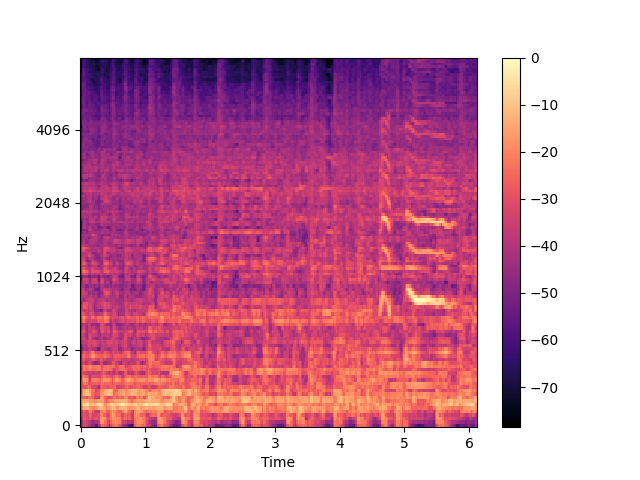
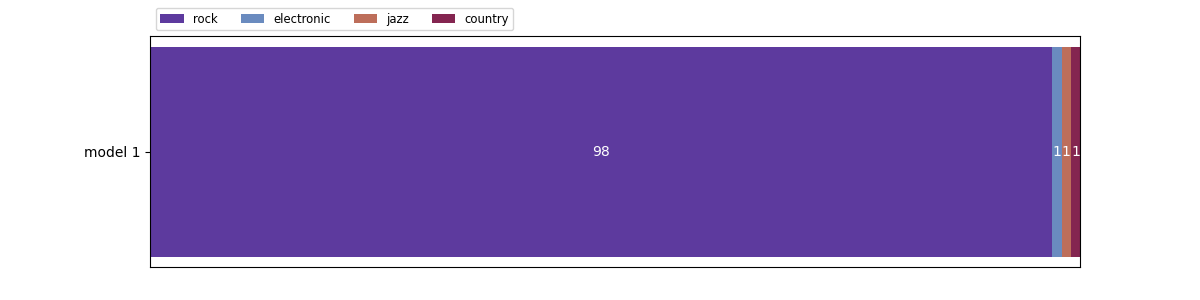
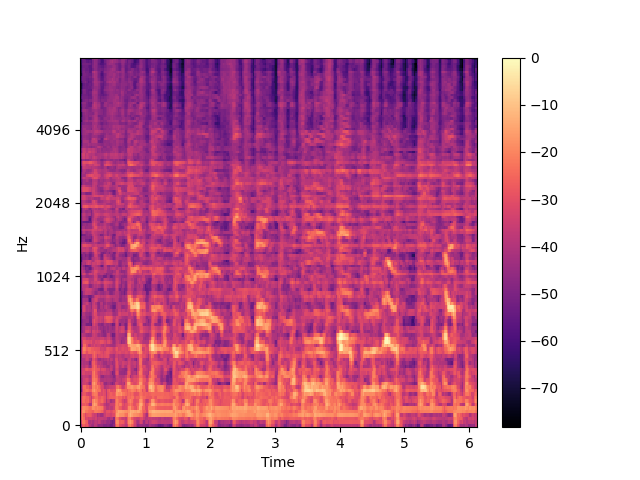
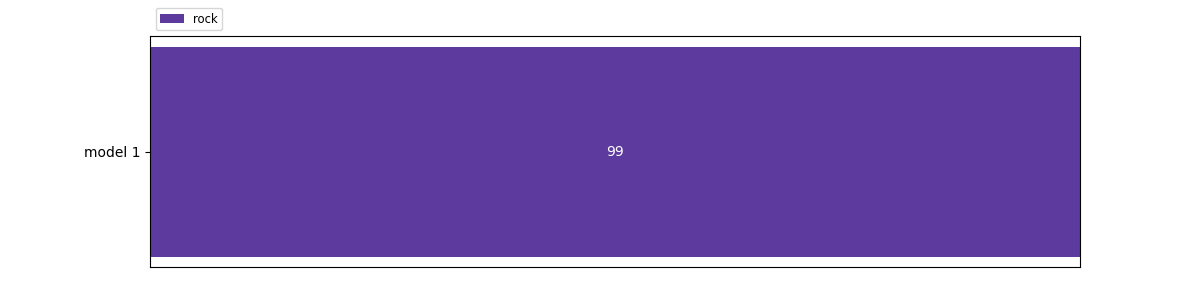
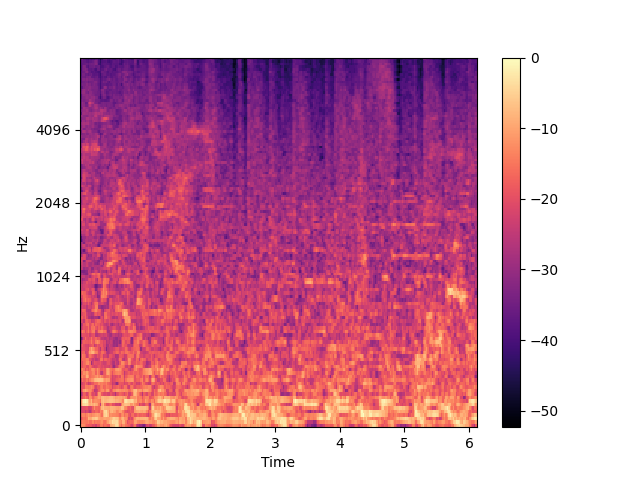
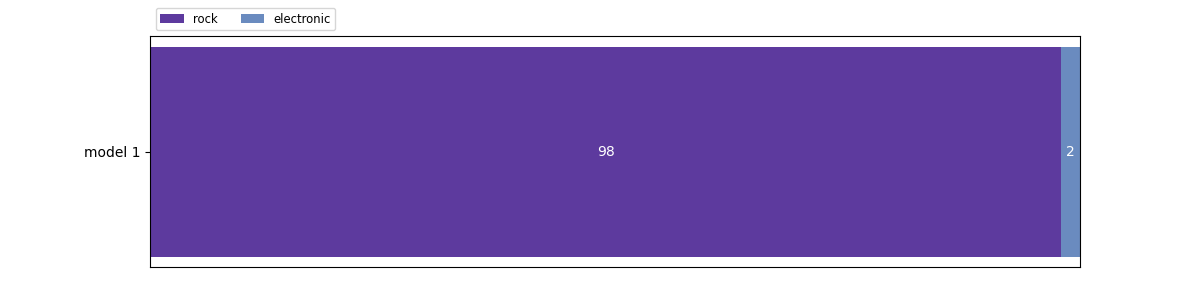
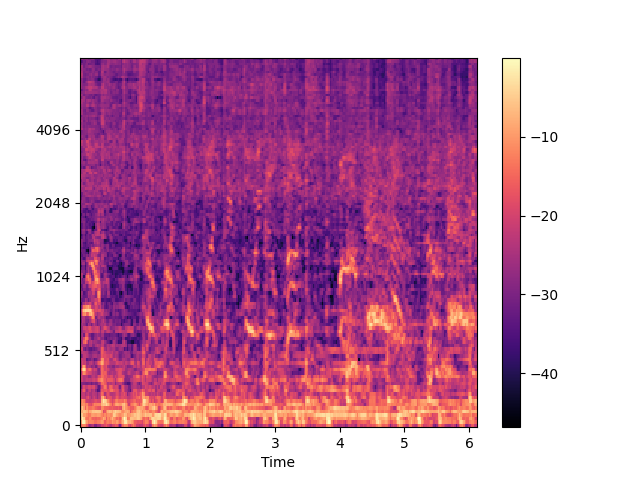
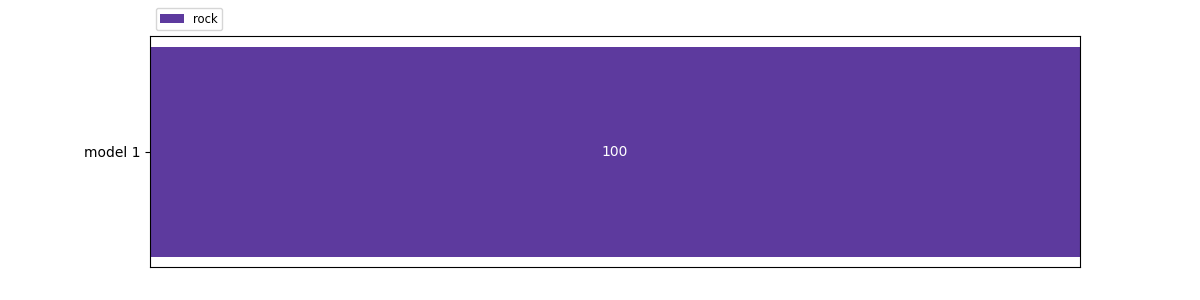
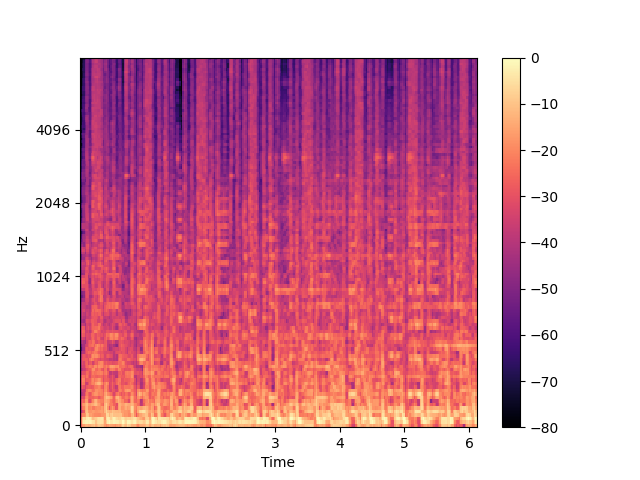
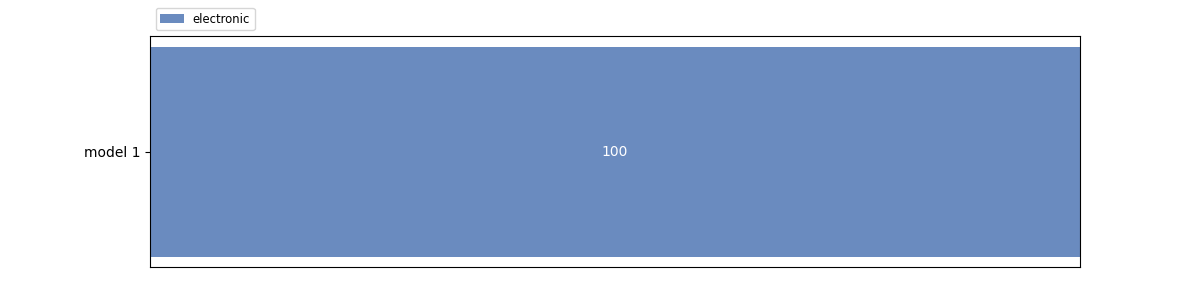
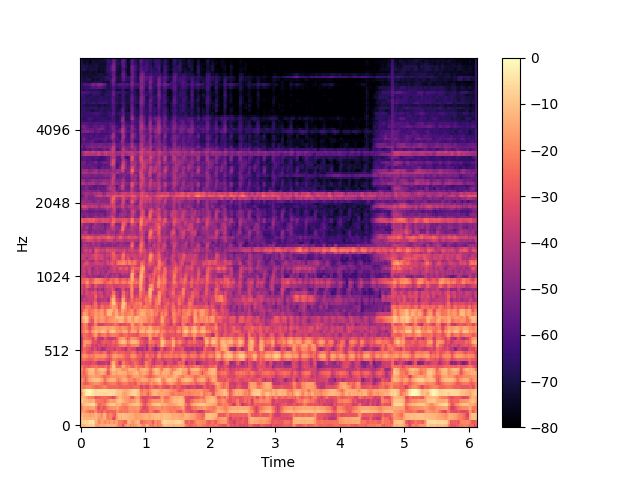
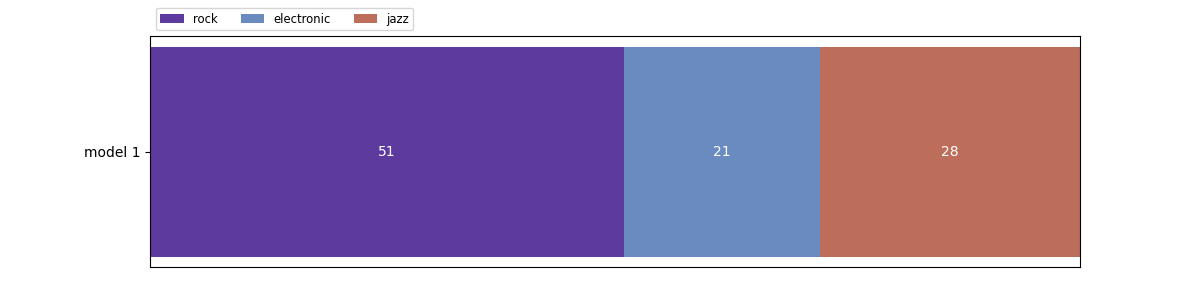
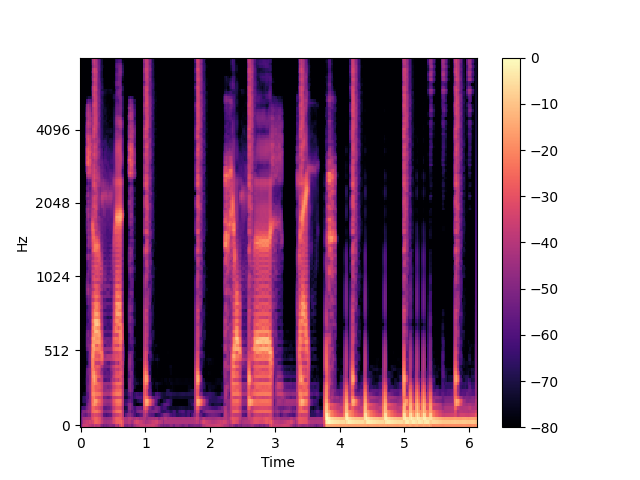
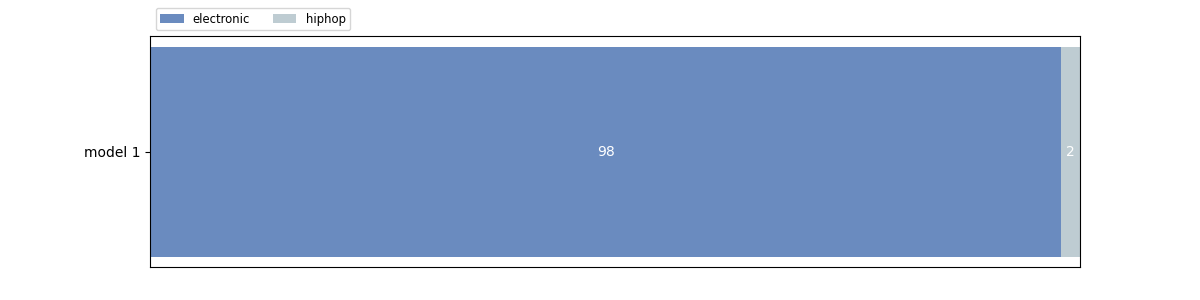
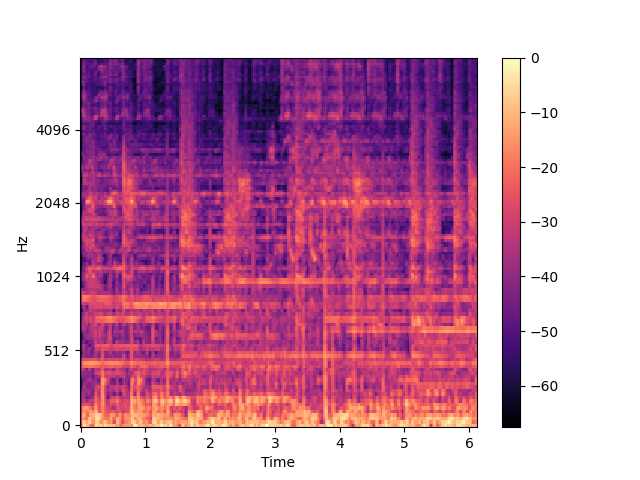
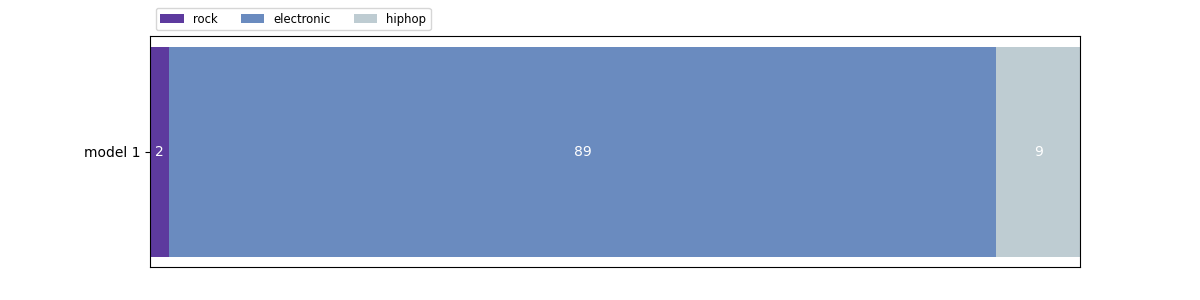
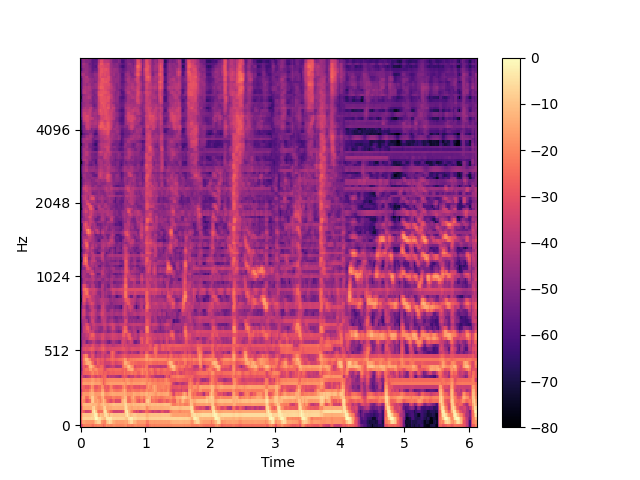
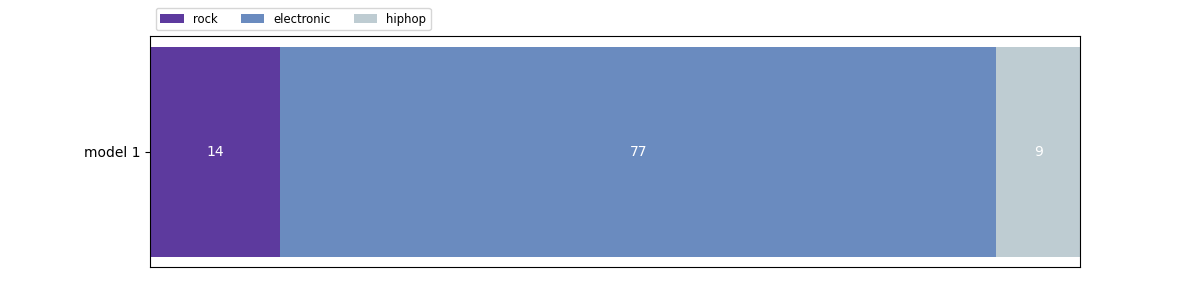
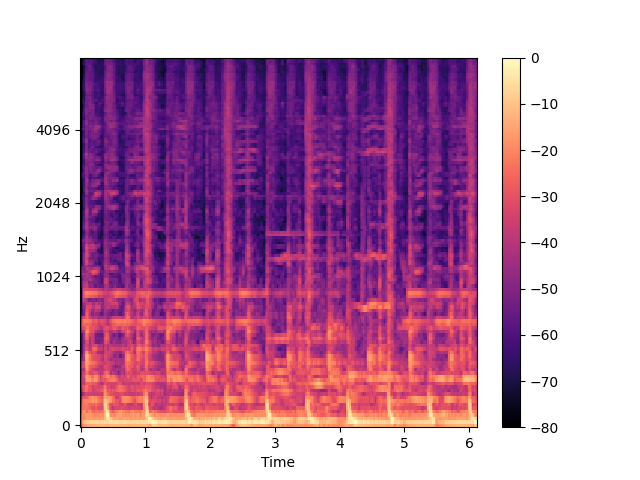
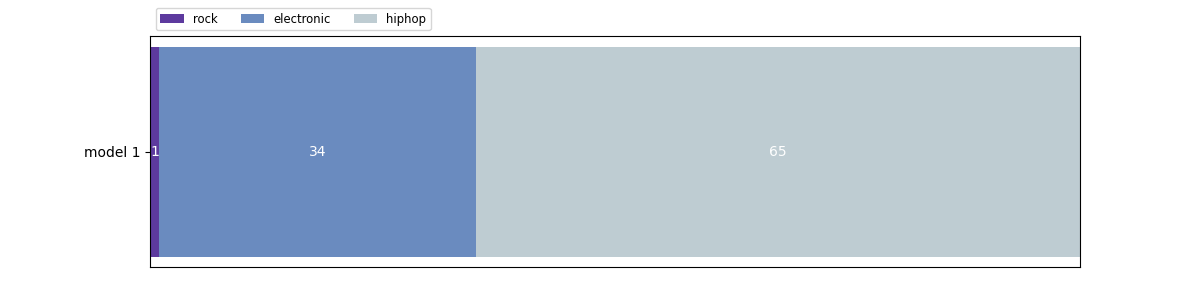
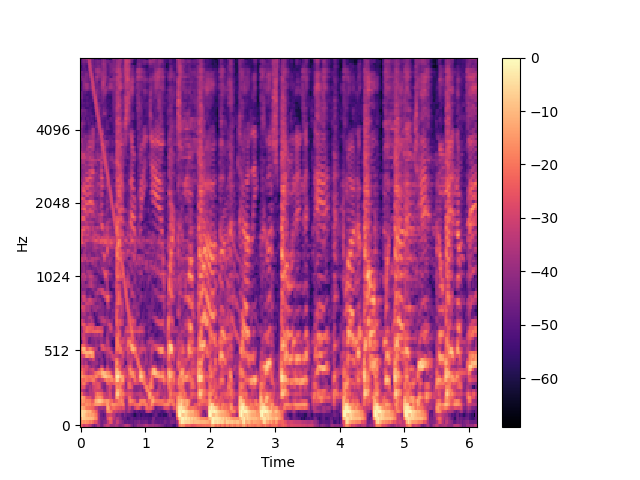
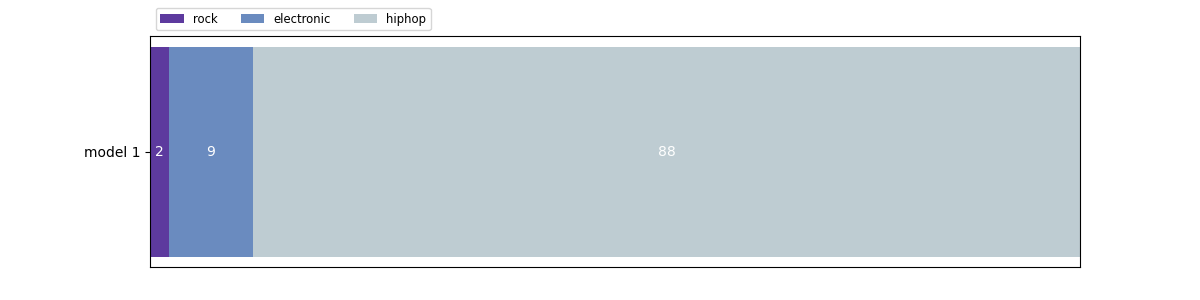
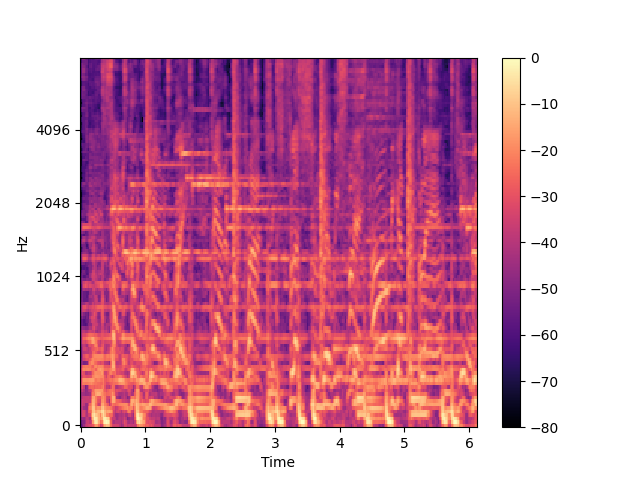
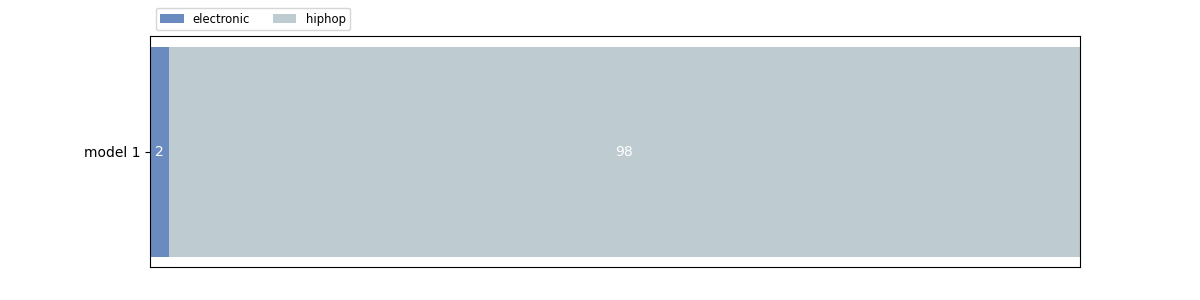
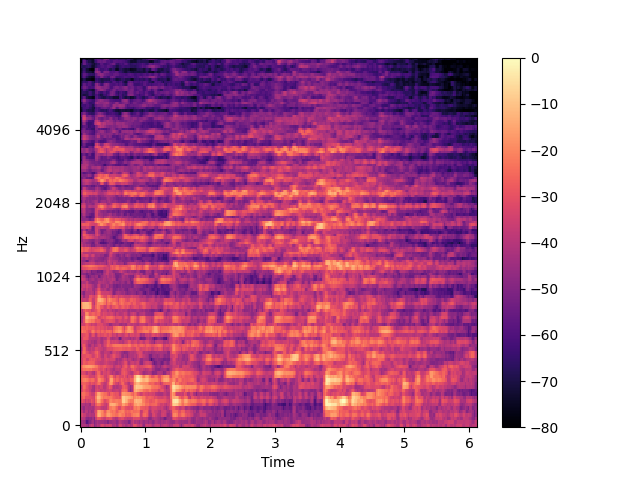
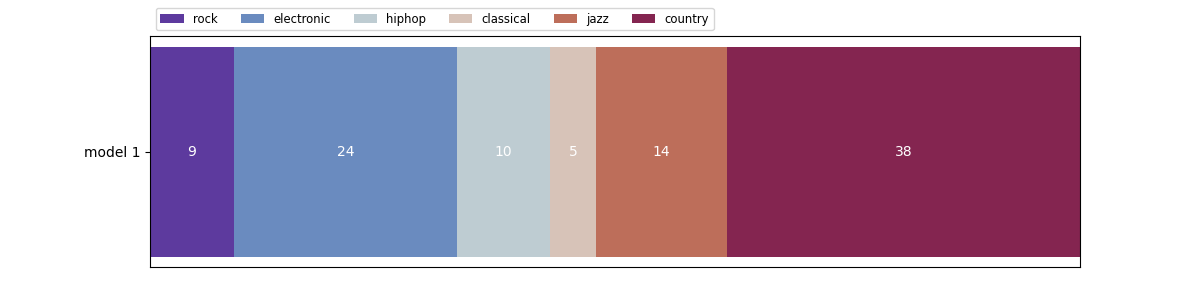
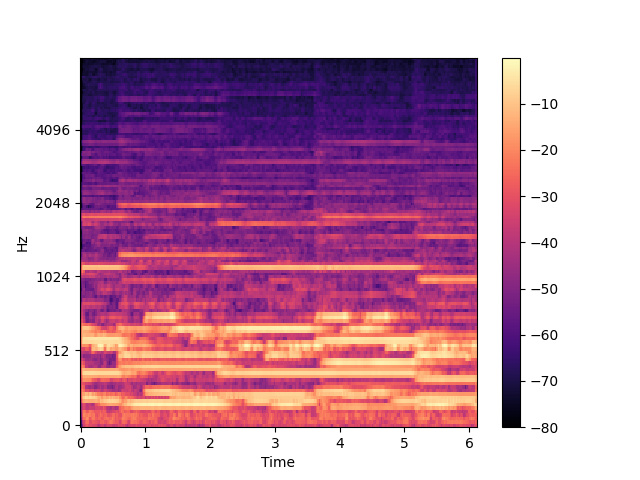
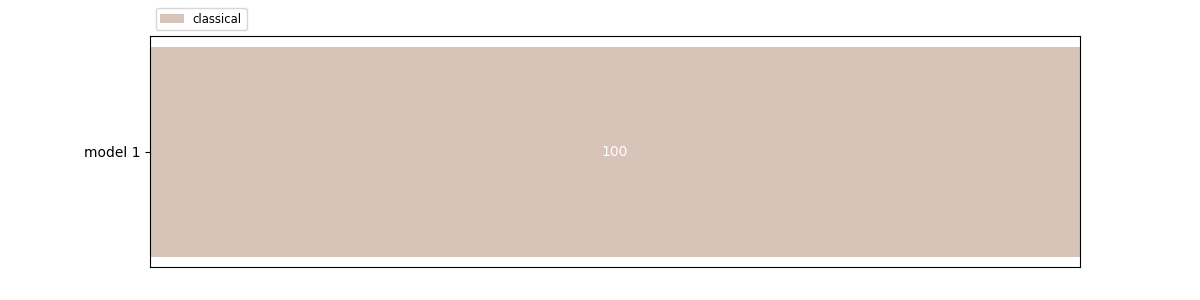
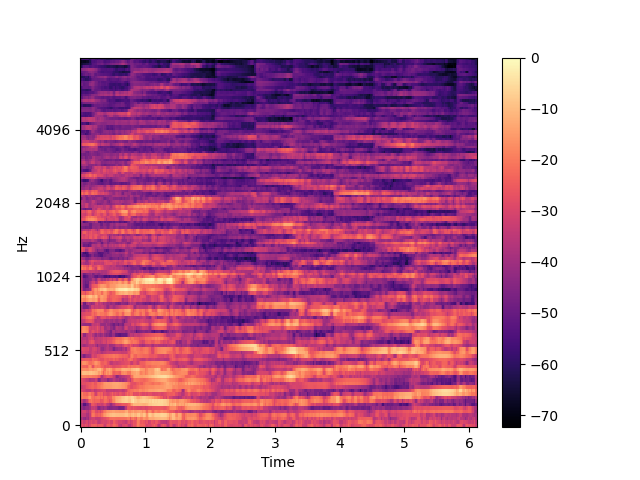
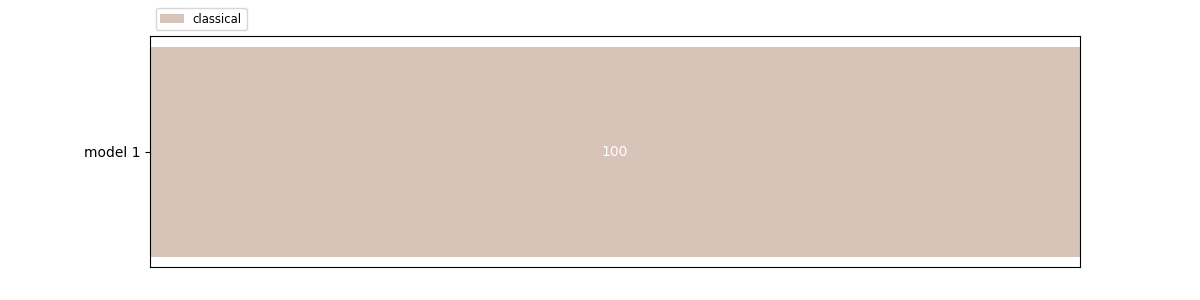
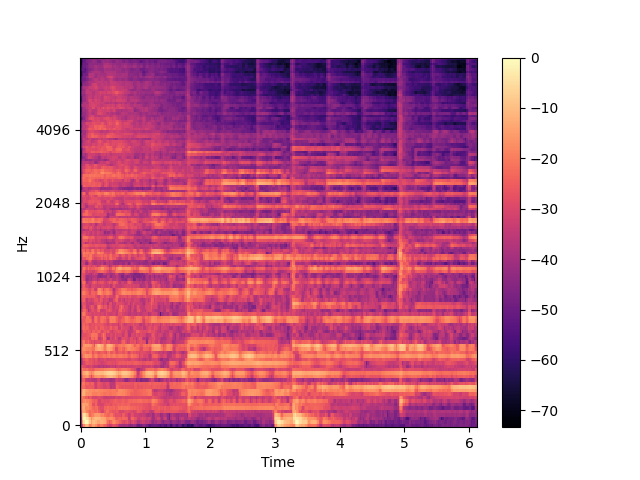
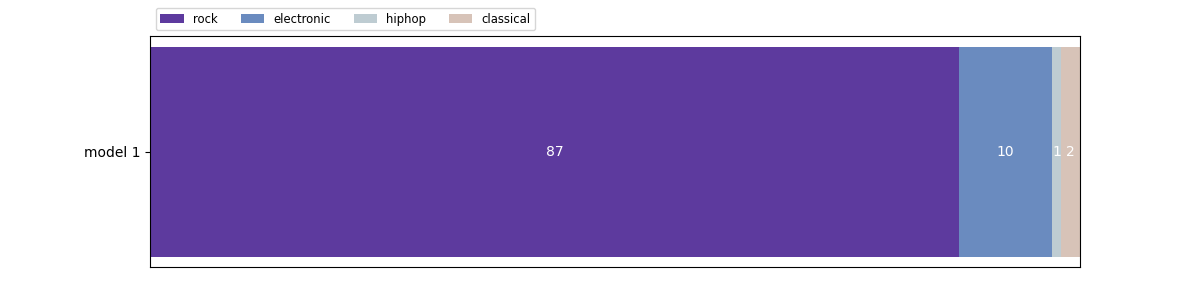
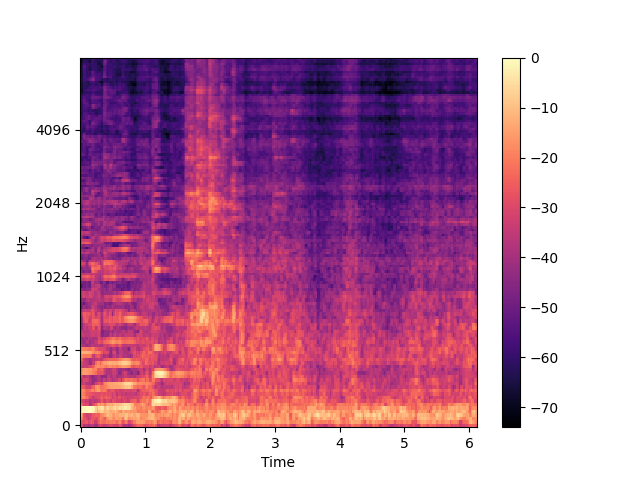
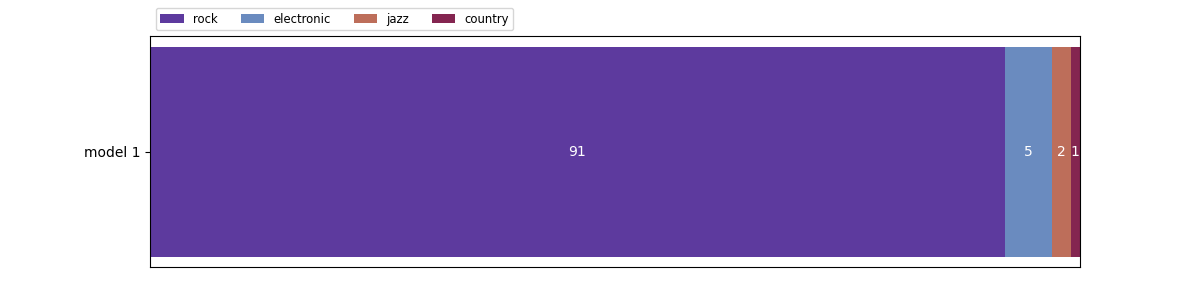
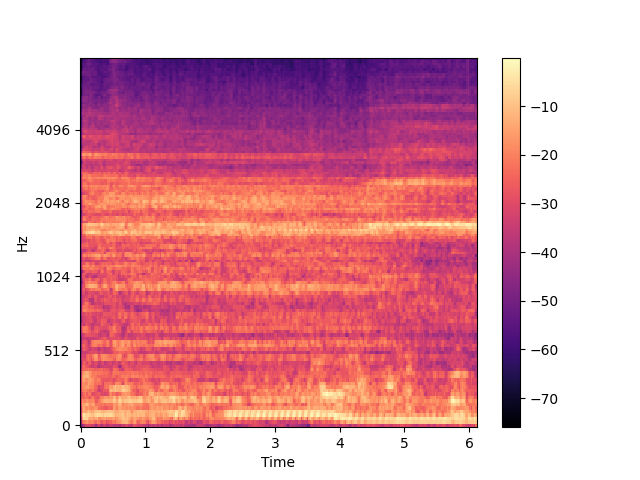
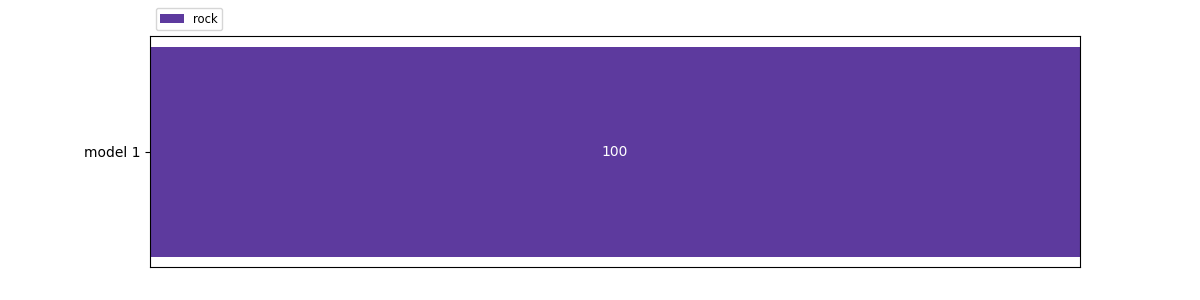
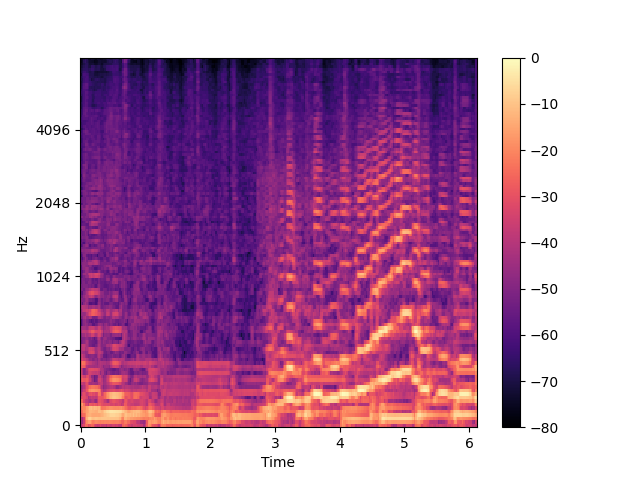
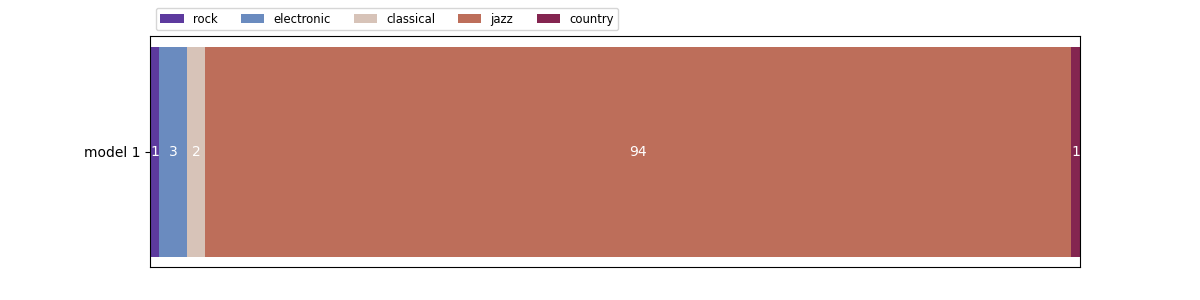
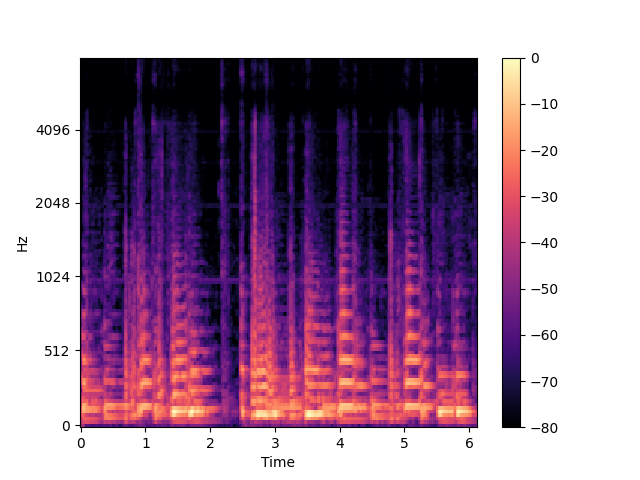
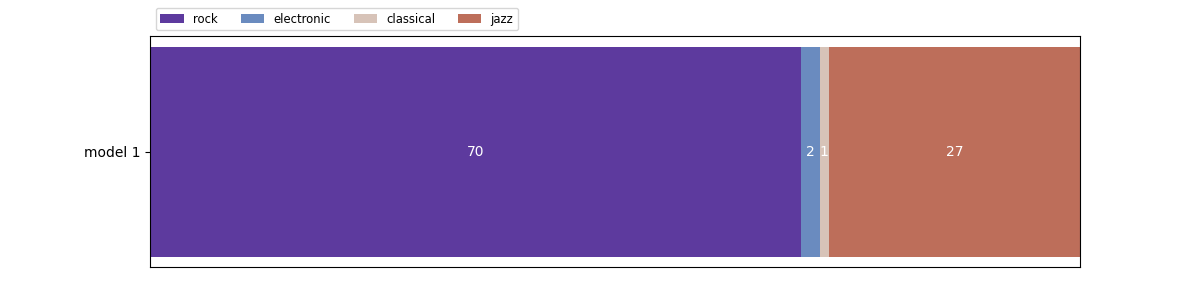
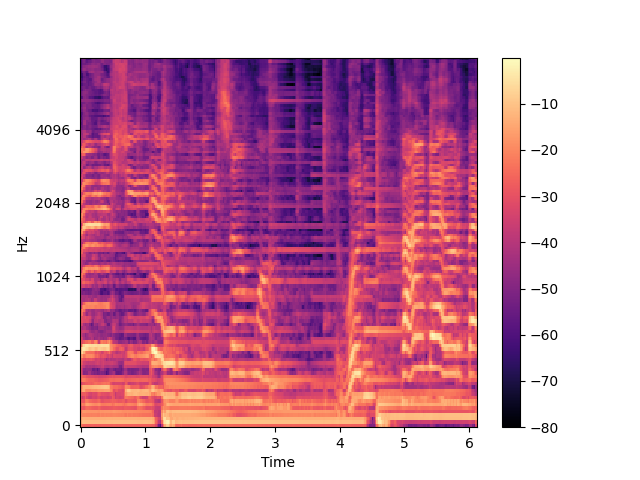
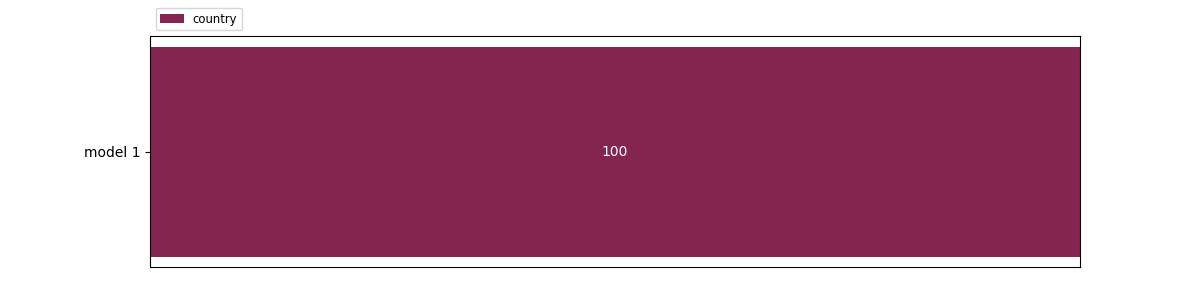
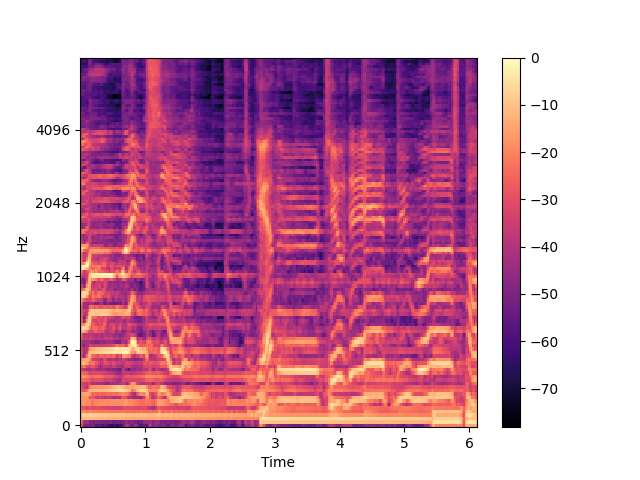
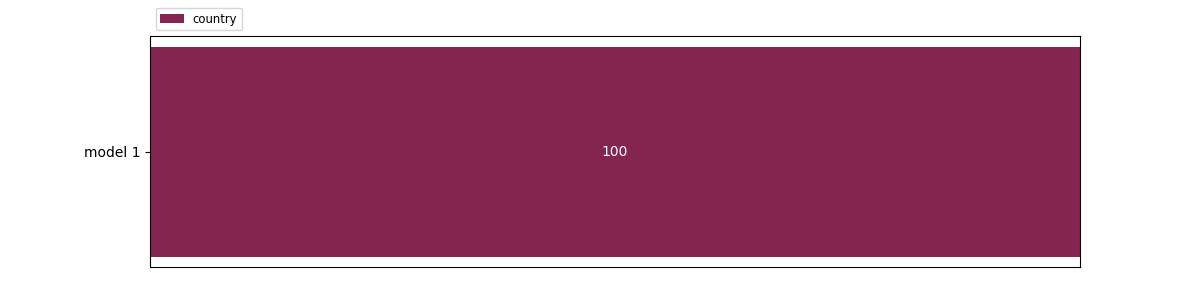
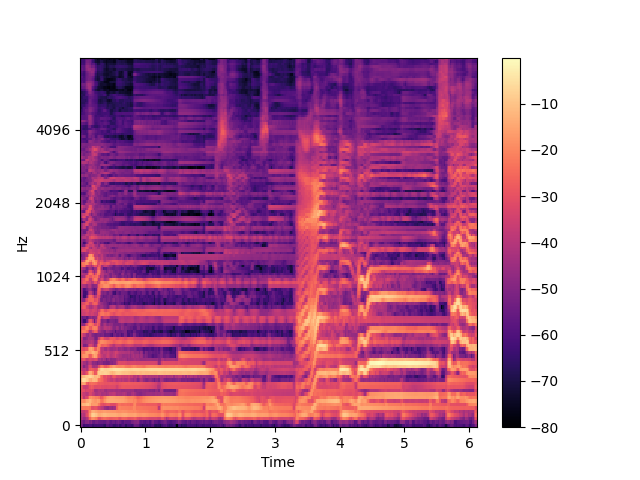
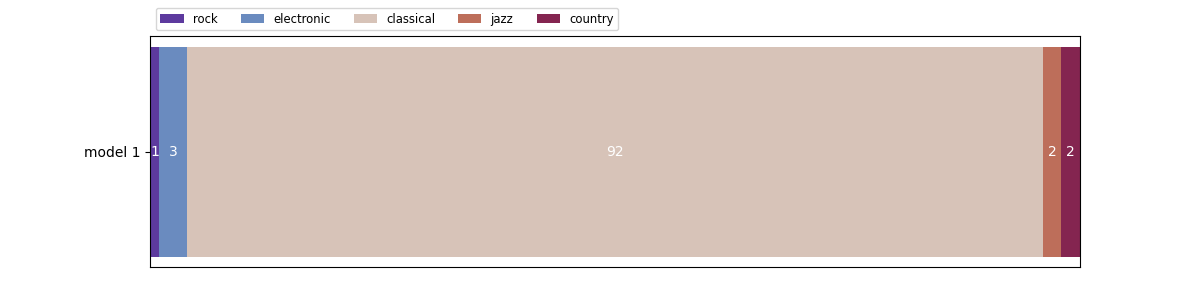
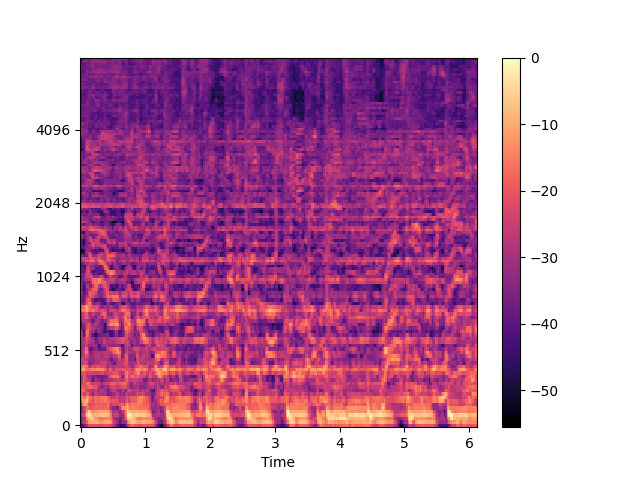
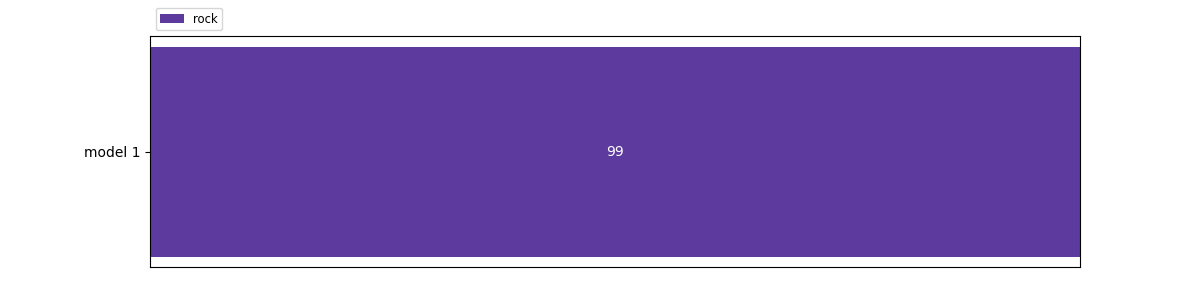

In [30]:
ipd.display(ipd.HTML(get_audio_browser_html(audio_browser_table_data)))

In [27]:
#print(table_html)

### Directly Display players, and plotly images

Showing Track:  118741 label is:  rock
Showing Track:  082076 label is:  electronic
Showing Track:  032957 label is:  hiphop
Showing Track:  050931 label is:  classical
Showing Track:  051935 label is:  jazz
Showing Track:  country.00034.wav label is:  country


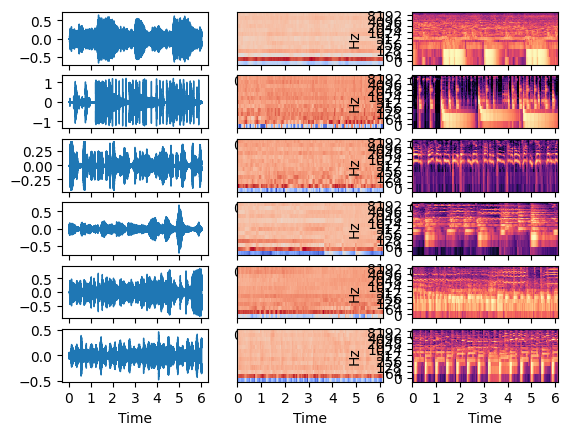

In [40]:
#to do: see if there is a way to filter out bad files 
#035394 - electronic? but more towards end 
#035453 - is jazz but doesn't sound like it 
#how to account fo music with differnet parts (predict each part and average the scores?)
audio.explore_features(12)

In [7]:
row_num = 0
track_id_ =audio.df['track_id'].iloc[row_num]
mfccs_ = audio.df['mfcc'].iloc[row_num]#[0: int(len(mfccs)/4)]
log_s_ =audio.df['log_melspectrogram'].iloc[row_num]
audio_ = audio.df['audio'].iloc[row_num]
sr_ = audio.df['sampling_rate'].iloc[row_num]
label_ = audio.df['label'].iloc[row_num]
print(label_)

rock


In [30]:
len(audio_), mfccs_.shape, log_s_.shape

(135000, (13, 264), (128, 264))

/var/folders/rt/w6xs9fcn3snbp_cdthc_kjww0000gq/T/ipykernel_41766/1519863365.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


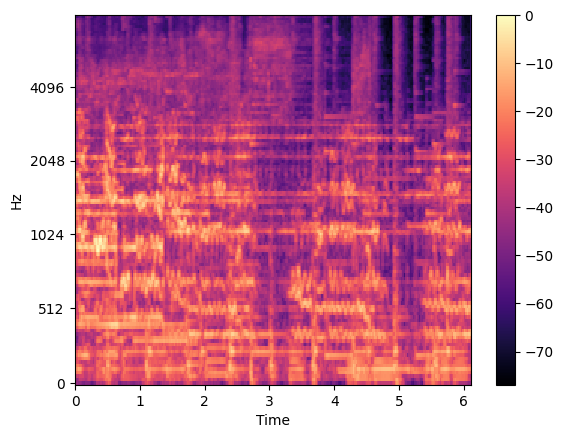

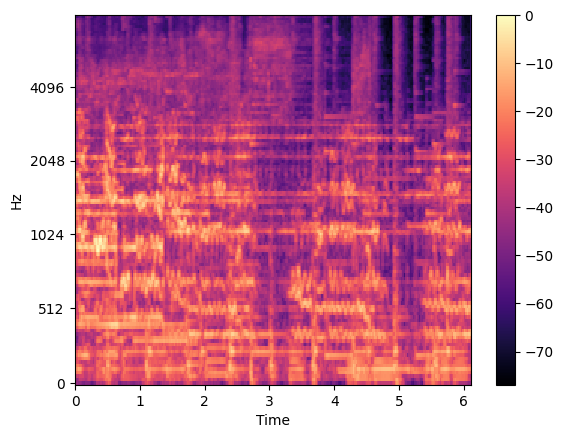

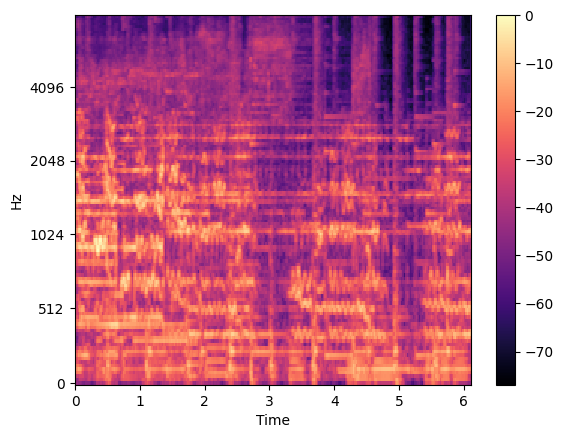

In [33]:
plt.ion()
fig, ax = plt.subplots()
spectro = librosa.display.specshow(log_s_,                                     x_axis='time', y_axis='mel', fmax=8000)
fig.colorbar(spectro, ax=ax)
fig.show()

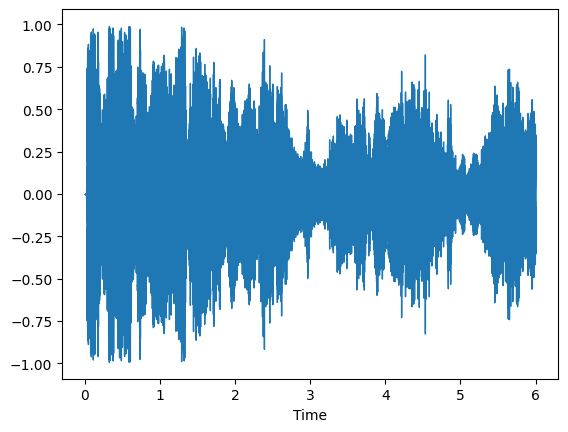

In [34]:
ipd.display(ipd.Audio(audio_, rate=sr_),
            librosa.display.waveshow(audio_, sr=sr_)                 
            )

In [35]:
mfccs_.shape, log_s_.shape

((13, 264), (128, 264))

[Text(0.5, 1.0, 'Mel Frequency Cepstral Coefficients (MFCC)')]

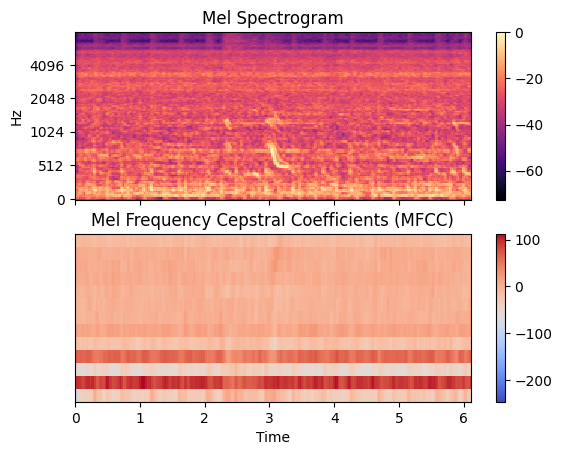

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True)
#'''
img = librosa.display.specshow(log_s_,
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
        
fig.colorbar(img, ax=[ax[0]])
#'''
ax[0].set(title='Mel Spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs_, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='Mel Frequency Cepstral Coefficients (MFCC)')

In [1]:
fig, ax = plt.subplots(nrows=2, sharex=True)
#'''
img = librosa.display.specshow(log_s_,
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
        
fig.colorbar(img, ax=[ax[0]])
#'''
ax[0].set(title='Mel Power spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs_, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

NameError: name 'plt' is not defined